## 기획자나 마케터가 되어 이벤트 댓글을 분석해 보자!
### 내가 만약 수백 수천개의 댓글을 다 읽어봐야 한다면?
### 댓글 속에 제품에 대한 관심을 빈도수로 추출해야 한다면?
* 쇼핑몰에서 제품 관련 이벤트 진행시 어떤 제품을 고객이 선호하는지 알고 싶다면?
* 고객 DB와 연계할 수 있다면 이벤트 혹은 마케팅 세그먼트로 활용해 볼 수도 있지 않을까?

### 향후 마케팅이나 전략을 어떻게 세워야 할까?

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline
# 시각화 결과가 선명하게 표시되도록
%config InlineBackend.figure_format = 'retina'

## 시각화를 위한 한글폰트 설정

In [2]:
# Window 한글폰트 설정
# plt.rc("font", family="Malgun Gothic")
# Mac 한글폰트 설정
plt.rc("font", family="AppleGothic")
plt.rc('axes', unicode_minus=False)

## 크롤링한 파일 로드하기

In [3]:
df = pd.read_csv("inflearn-event.csv")
df.shape

(1652, 1)

In [4]:
df.head()

,text
0,비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...
1,취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...
2,자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링
3,컴퓨터사이언티스트로 성장하기 위해 선형대수 공부를 하려고 합니다\n#관심강의: 선형...
4,웹 개발자로서 더욱 성장하고 싶어 jpa와 스프링 강의를 듣고 싶습니다.\n# 관심...


In [5]:
df.tail()

,text
1647,"작년 한해도 일이 바쁘다, 야근해서 힘들다는 핑계로 김영한님의 JPA 강의를 또 스..."
1648,저는 졸업을 1년 남기고 있는 컴퓨터공학과 학생입니다. 졸업 프로젝트로 웹/앱 개발...
1649,"에프터 이펙트를 써본 적은 있는데, 매번 기초만 배우다 말았어요. 이걸 할 줄 안다..."
1650,저번에 인프런에서 페이스북 마케팅 강의를 듣고 많은 도움을 받았습니다. 마케팅 업무...
1651,인프런 0호 팀원이에요!\n그동안 서비스 개발 때문에 js 를 많이 했었는데 앞으론...


## 데이터 전처리

### 네트워크 오류 등으로 발생한 중복 입력 값을 제거
* 빈도 수 중복을 방지하기 위해

In [6]:
print(df.shape)
df = df.drop_duplicates(["text"], keep="last")
print(df.shape)

(1652, 1)
(1627, 1)


### 원본은 따로 보존

In [7]:
# 전처리 전에 원본을 보존하기 위해 복사해 둠
df["origin_text"] = df["text"]
df.head()

,text,origin_text
0,비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...,비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...
1,취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...,취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...
2,자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링,자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링
3,컴퓨터사이언티스트로 성장하기 위해 선형대수 공부를 하려고 합니다\n#관심강의: 선형...,컴퓨터사이언티스트로 성장하기 위해 선형대수 공부를 하려고 합니다\n#관심강의: 선형...
4,웹 개발자로서 더욱 성장하고 싶어 jpa와 스프링 강의를 듣고 싶습니다.\n# 관심...,웹 개발자로서 더욱 성장하고 싶어 jpa와 스프링 강의를 듣고 싶습니다.\n# 관심...


### 소문자 변환

In [8]:
# 파이썬은 대소문자를 구분하기 때문에 데이터 필터링을 위해 대문자를 모두 소문자로 변경
df["text"] = df["text"].str.lower()

In [9]:
# 같은 의미의 단어를 하나로 통일 예) python => 파이썬
df["text"] = df["text"].str.replace(
    "python", "파이썬").str.replace(
    "pandas", "판다스").str.replace(
    "javascript", "자바스크립트").str.replace(
    "java", "자바").str.replace(
    "react", "리액트")

### 텍스트로 관심 강의 분리

In [10]:
df["course"] = df["text"].apply(lambda x: x.split("관심강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강좌")[-1])
df["course"] = df["course"].str.replace(":", "")
df["course"].head()

0    비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...
1    취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...
2                      자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링
3                                        선형대수학개론 (조범희)
4                                            스프링 웹 mvc
Name: course, dtype: object

In [11]:
df[["text", "course"]].head()

,text,course
0,비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...,비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...
1,취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...,취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...
2,자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링,자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링
3,컴퓨터사이언티스트로 성장하기 위해 선형대수 공부를 하려고 합니다\n#관심강의: 선형...,선형대수학개론 (조범희)
4,웹 개발자로서 더욱 성장하고 싶어 jpa와 스프링 강의를 듣고 싶습니다.\n# 관심...,스프링 웹 mvc


## 띄어 쓰기를 제거한 텍스트에서 키워드 추출
* TIOBE 프로그래밍 언어 순위 : [index | TIOBE - The Software Quality Company](https://www.tiobe.com/tiobe-index/?fbclid=IwAR34dJfgDHq2DK0C6X3g8IsUno2NhOiikMyxT6fw9SoyujFhy5FPvQogMoA)

In [12]:
search_keyword = ['머신러닝', '딥러닝', '파이썬', '판다스', '공공데이터',
                  'django', '크롤링', '시각화', '데이터분석', 
                  '웹개발', '엑셀', 'c', '자바', '자바스크립트', 
                  'node', 'vue', '리액트']

for keyword in search_keyword:
    df[keyword] = df["course"].str.contains(keyword)

In [13]:
df.head()

,text,origin_text,course,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트
0,비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...,비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...,비전공자로서 인프런과 독학하고있습니다. 더 많은 내용들을 배우고 지식을 얻고 싶습니...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...,취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...,취업준비생으로 앞으로 인프런을 많이 이용할겁니다 전에도 결제했지만 이런 이벤트와 할...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링,자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링,자바를 심도있게 배우기위해 스프링을 공부합니다\n#스프링,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,컴퓨터사이언티스트로 성장하기 위해 선형대수 공부를 하려고 합니다\n#관심강의: 선형...,컴퓨터사이언티스트로 성장하기 위해 선형대수 공부를 하려고 합니다\n#관심강의: 선형...,선형대수학개론 (조범희),False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,웹 개발자로서 더욱 성장하고 싶어 jpa와 스프링 강의를 듣고 싶습니다.\n# 관심...,웹 개발자로서 더욱 성장하고 싶어 jpa와 스프링 강의를 듣고 싶습니다.\n# 관심...,스프링 웹 mvc,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [14]:
df_python = df[df["text"].str.contains("파이썬|공공데이터|판다스")].copy()
df_python.shape

(283, 20)

In [15]:
True + True + False

2

In [16]:
df[search_keyword].sum().sort_values(ascending=False)

파이썬       265
c         259
자바        225
자바스크립트     97
머신러닝       91
리액트        90
vue        87
node       86
딥러닝        37
크롤링        33
django     25
웹개발        22
시각화        21
데이터분석      18
엑셀         12
공공데이터       3
판다스         3
dtype: int64

In [17]:
text = df.loc[(df["공공데이터"] == True), "text"]
for t in text:
    print("-"*20)
    print(t)

--------------------
경영학과 졸업생입니다. 새해엔 엑셀! 파이썬! 취직! 해내겠습니다. 좋은 강의, 커리큘럼이 있는 인프런 너무 감사합니다 ~^^
#관심강의: 공공데이터로 분석하기
--------------------
인프런으로 파이썬 기초문법부터 입문했어요! 실무 데이터분석에 활용할 수 있는 수준으로 실력을 올리고 싶습니다:)
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
나만의 프로젝트 하나 완성할 수 있을 정도의 지식 쌓기!
#관심강의:공공데이터로 파이썬 데이터 분석 시작하기


## 판다스 단어가 들어가는 텍스트만 찾기
* 이미 str.contains 를 통해 판다스가 들어가는 텍스트에 대해 컬럼을 만들어 놨습니다. 이 값이  True 라면 판다스 강좌 입니다.

In [18]:
df.loc[df["판다스"] == True, "text"]

439       2020년!! 올 해는 빅데이터 분석 전문가 되기!!\n#관심강의 : 파이썬, 판다스
1358    2020년 목표  파이썬 을  활용해  데이터 분석 작업을 진행하고 싶습니다.  관...
1568    저는 백세시대에 조금 더 오랫동안 it일을 하기위해서 it전략기획에서 데이터분석가로...
Name: text, dtype: object

## 빈도수 계산을 위한 텍스트 데이터 벡터화
* BOW 단어 가방에 단어를 토큰화 해서 담아줌

In [19]:
# 토큰화
"파이썬 데이터 분석".split()

['파이썬', '데이터', '분석']

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
                             ngram_range=(3, 6), # BOW의 단위 갯수의 범위를 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=2,
                ngram_range=(3, 6), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [21]:
feature_vector = vectorizer.fit_transform(df['course'])
feature_vector.shape

(1627, 1643)

In [22]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

1643


['12개 만들면서 배우는',
 '12개 만들면서 배우는 ios',
 '12개 만들면서 배우는 ios 아이폰',
 '12개 만들면서 배우는 ios 아이폰 개발',
 '12개를 만들며 배우는',
 '12개를 만들며 배우는 swift4',
 '12개를 만들며 배우는 swift4 ios11',
 '12개를 만들며 배우는 swift4 ios11 아이폰',
 '2018 do it',
 '2018 do it 안드로이드']

In [23]:
# 각 리뷰마다 등장하는 단어에 빈도수가 표현됩니다. 0 은 등장하지 않음을 의미합니다.
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head()

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용1 애플리케이션 개발,활용2 api 개발과,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# 위에서 구한 단어벡터를 더하면 단어가 전체에서 등장하는 횟수를 알 수 있습니다.
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)
    
df_freq = pd.DataFrame(dist, columns=vocab)
df_freq

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용1 애플리케이션 개발,활용2 api 개발과,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발
0,2,2,2,2,2,2,2,2,2,2,...,18,9,9,9,7,7,6,2,3,3


In [25]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬
df_freq.T.sort_values(by=0, ascending=False).head(100)

,0
홍정모의 따라하며 배우는,64
스프링 데이터 jpa,43
파이썬 머신러닝 완벽,38
머신러닝 완벽 가이드,38
nodebird sns 만들기,37
파이썬 머신러닝 완벽 가이드,37
관심있는 인프런 강의명,35
2020년 공부 목표,33
리액트로 nodebird sns,32
리액트로 nodebird sns 만들기,32


## TF-IDF 로 가중치를 주어 벡터화
### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정합니다.
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값(유클리디안거리)
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절(맨하탄거리)
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [27]:
%%time 
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

CPU times: user 3.19 ms, sys: 1.71 ms, total: 4.9 ms
Wall time: 4.04 ms


(1627, 1643)

In [28]:
feature_tfidf

<1627x1643 sparse matrix of type '<class 'numpy.float64'>'
	with 7574 stored elements in Compressed Sparse Row format>

In [29]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector에 TF-IDF 가중치 반영
tfidf_freq = pd.DataFrame(feature_tfidf.toarray(), columns=vocab)
tfidf_freq.head() 

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용1 애플리케이션 개발,활용2 api 개발과,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df_tfidf = pd.DataFrame(tfidf_freq.sum())
df_tfidf_top = df_tfidf.sort_values(by=0, ascending=False)
df_tfidf_top.head(20)

,0
홍정모의 따라하며 배우는,39.067823
스프링 데이터 jpa,26.499778
파이썬 머신러닝 완벽,18.861958
머신러닝 완벽 가이드,18.597056
파이썬 머신러닝 완벽 가이드,17.962096
nodebird sns 만들기,17.361798
리액트로 nodebird sns 만들기,16.017216
리액트로 nodebird sns,16.017216
부트 개념과 활용,11.538699
스프링 부트 개념과,11.061760


In [31]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
for t in df_tfidf_top.index[:50]:
    print(t)

홍정모의 따라하며 배우는
스프링 데이터 jpa
파이썬 머신러닝 완벽
머신러닝 완벽 가이드
파이썬 머신러닝 완벽 가이드
nodebird sns 만들기
리액트로 nodebird sns 만들기
리액트로 nodebird sns
부트 개념과 활용
스프링 부트 개념과
관심있는 인프런 강의명
스프링 부트 개념과 활용
함수형 프로그래밍과 자바스크립트
함수형 프로그래밍과 자바스크립트 es6
프로그래밍과 자바스크립트 es6
실전 스프링 데이터
2020년 공부 목표
대세는 쿠버네티스 기초편
실전 스프링 데이터 jpa
rest api 개발
파이썬 실전 100
남박사의 파이썬 실전 100
남박사의 파이썬 실전
남박사의 파이썬 실전 100 활용
실전 100 활용
파이썬 실전 100 활용
파이썬 머신러닝 완벽가이드
js 완벽 가이드
vue js 완벽
vue js 완벽 가이드
스프링 기반 rest
스프링 기반 rest api
스프링 기반 rest api 개발
기반 rest api
기반 rest api 개발
스프링 부트와 jpa
홍정모의 따라하며 배우는 c언어
따라하며 배우는 c언어
스프링부트 개념과 활용
모두를 위한 딥러닝
node js 교과서
실전 스프링 부트와 jpa
실전 스프링 부트와
자바 애플리케이션을 테스트하는 다양한
애플리케이션을 테스트하는 다양한
자바 애플리케이션을 테스트하는
ios12 개발 퍼펙트
개발 퍼펙트 가이드
ios12 개발 퍼펙트 가이드
자바 애플리케이션을 테스트하는 다양한 방법


## 군집화 
* [Comparison of the K-Means and MiniBatchKMeans clustering algorithms — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)
* cluster - MiniBatchKMeans

In [32]:
from sklearn.cluster import KMeans
from tqdm import trange
inertia = []

start = 10
end = 50

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
for i in trange(start, end):
    cls = KMeans(n_clusters=i, random_state=42)
    cls.fit(feature_vector)
    inertia.append(cls.inertia_)

100%|██████████| 40/40 [00:24<00:00,  1.41it/s]


Text(0.5, 1.0, 'KMeans 클러스터 수 비교')

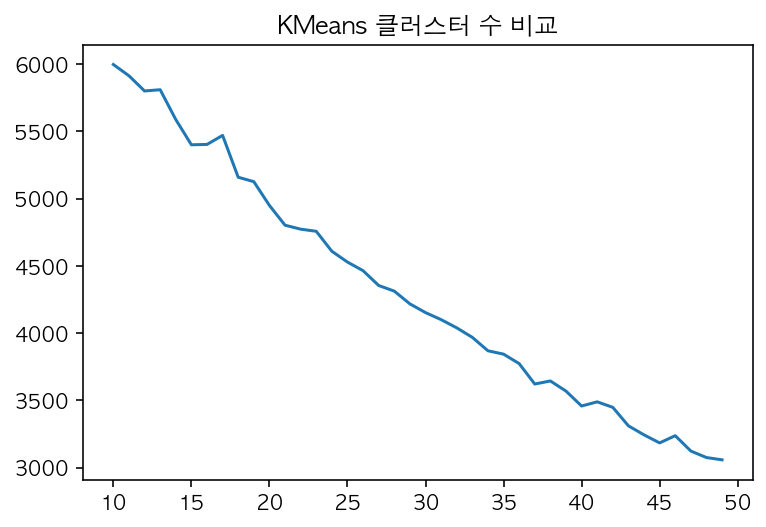

In [33]:
plt.plot(range(start, end), inertia)
plt.title("KMeans 클러스터 수 비교")

In [34]:
n_clusters = 30
cls = KMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_vector)
predict = cls.predict(feature_vector)
df["cluster"] = predict

In [35]:
df["cluster"].value_counts().head(10)

0     1357
5       34
6       23
21      21
8       20
14      20
19      17
2       17
28      15
4       10
Name: cluster, dtype: int64

In [36]:
# batch_size 를 쓸 수 있는 MiniBatchKMeans 로 군집화
from sklearn.cluster import MiniBatchKMeans
b_inertia = []

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
for i in trange(start, end):
    cls = MiniBatchKMeans(n_clusters=i, random_state=42)
    cls.fit(feature_vector)
    b_inertia.append(cls.inertia_)

100%|██████████| 40/40 [00:03<00:00,  8.09it/s]


Text(0.5, 1.0, 'MiniBatchKMeans 클러스터 수 비교')

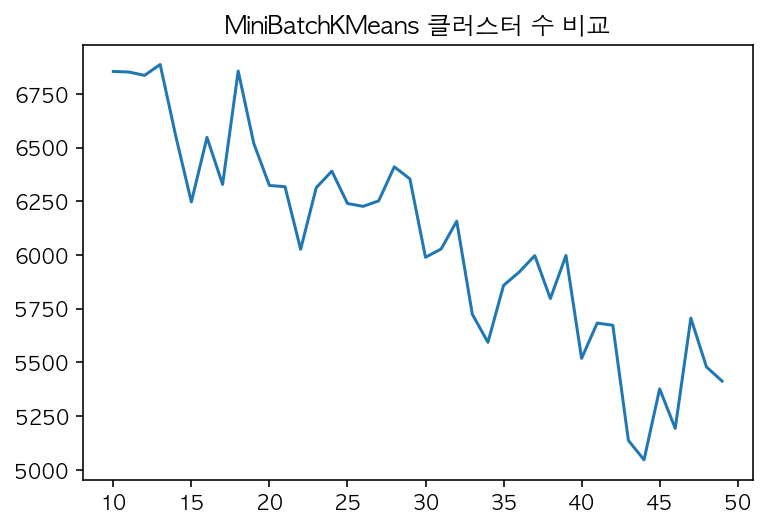

In [37]:
plt.plot(range(start, end), b_inertia)
plt.title("MiniBatchKMeans 클러스터 수 비교")

In [38]:
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_vector)
predict = cls.predict(feature_vector)
df["bcluster"] = predict

In [39]:
df["bcluster"].value_counts()

26    814
0     322
19     46
12     43
3      40
11     35
16     35
18     30
27     30
15     28
8      22
20     21
10     20
4      20
2      18
6      17
7      15
24     15
1      13
9      11
25      6
22      6
14      5
17      5
23      4
21      2
29      2
5       1
13      1
Name: bcluster, dtype: int64

In [40]:
df.loc[df["bcluster"] == 25, ["bcluster", "cluster", "course"]]

,bcluster,cluster,course
590,25,0,내 손으로 만드는 django 2.x 인스타그램 클론 강의
869,25,0,내 손으로 만드는 django 2.x 인스타그램 클론 강의
929,25,0,내 손으로 만드는 django 2.x 인스타그램 클론 강의
1004,25,0,내 손으로 만드는 django 2.x 인스타그램 클론 강의
1467,25,0,내 손으로 만드는 django 2.x 인스타그램 클론 강의
1469,25,27,"내 손으로 만드는 django 2.x 인스타그램 클론 강의,코알못에서 웹서비스 런칭..."


In [41]:
df.loc[df["bcluster"] == 22, ["bcluster", "cluster", "origin_text", "course"]].tail(10)

,bcluster,cluster,origin_text,course
57,22,0,"어릴때부터 프로그램같은거 만들어 보는게 너무 재미있어 보이기도하고,\n어릴때 기준으...",자바 스프링 프레임워크(renewal ver.) - 신입 프로그래머를 위한 강좌
181,22,0,개념을 복습하기 위해 공부하려합니다 \n\n자바 스프링 프레임워크(renew ver...,개념을 복습하기 위해 공부하려합니다 \n\n자바 스프링 프레임워크(renew ver...
379,22,0,컴공과 학생입니다. 아직 진로를 정하지 못해서 다양한 분야를 공부해보고 싶습니다!\...,홍정모의 게임 만들기 연습문제 패키지
943,22,0,2020년에는 취업을 위한 자바 개발자 로드맵을 다 따라 완성한 후! 정말로 자바 ...,자바 스프링 프레임워크
1235,22,0,프론트 엔드 개발자로서 실력을 키우고 싶습니다!\n\n# 관심강의 : 백기선님의 S...,백기선님의 spring 관련 강좌
1239,22,0,이제 1년정도 되어가는 신입개발자로써 올해 목표는\nspring관련 심화과정 학습 ...,\n백기선님의 spring 관련 강좌


## WordCloud
* [amueller/word_cloud: A little word cloud generator in Python](https://github.com/amueller/word_cloud)
* 설치 방법 : [Wordcloud :: Anaconda Cloud](https://anaconda.org/conda-forge/wordcloud)

In [42]:
from wordcloud import WordCloud

# 불용어 - 자주 등장하지만 의미가 크지 않아 제외하고 싶은 텍스트
stopwords = ["관심 강의", "관심강의", "관심", "강의", "강좌", "강의를",
             "올해", "올해는", "열심히", "공부를", "합니다", "하고", "싶어요", 
             "있는", "있습니다", "싶습니다", "2020년"]
# 불용어를 제거하지 않고 그리려면 아래 주석을 풀어서 stopword 변수에 덮어쓰기를 합니다.
# stopwords = []
def displayWordCloud(data = None, backgroundcolor = 'white', width=1280, height=768):
    wordcloud = WordCloud(
                        font_path = '/Library/Fonts/NanumBarunGothic.ttf', 
                        stopwords = stopwords, 
                        background_color = backgroundcolor, 
                        width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

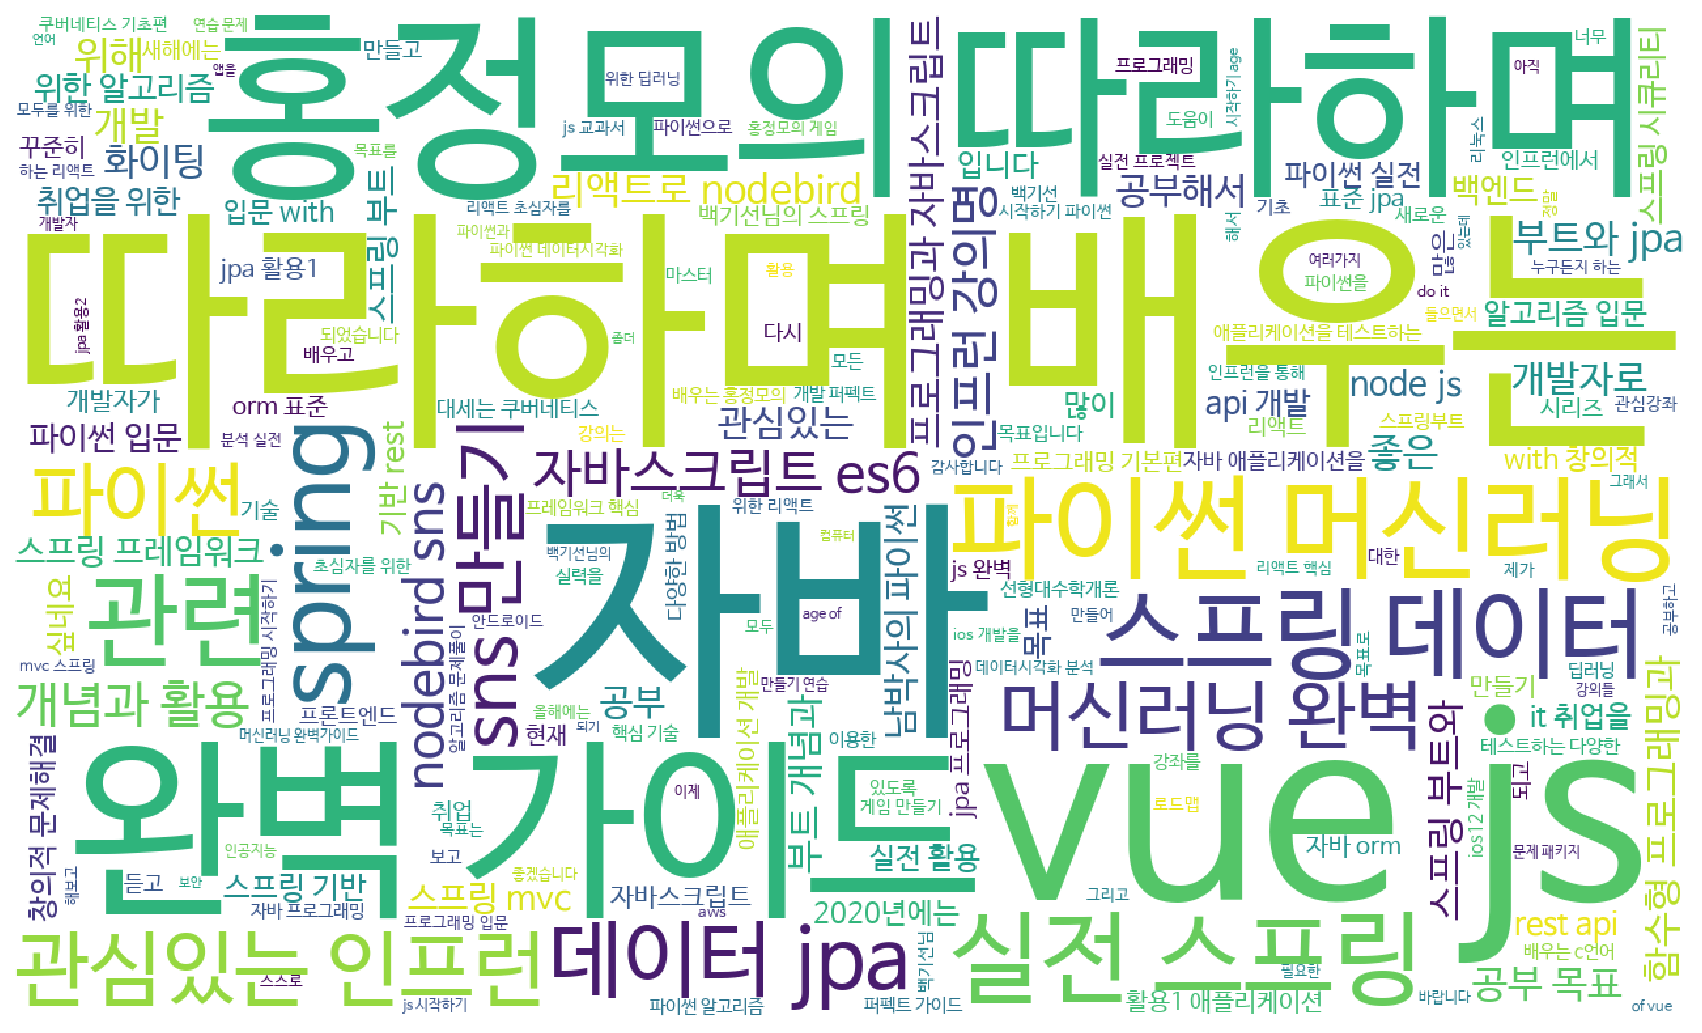

In [43]:
course_text = " ".join(df["course"])
displayWordCloud(course_text)